# Amazon food review dataset apply naive bayes

Data set from https://www.kaggle.com/snap/amazon-fine-food-reviews

# Objective
1. Try predicting review using naive bayes and tunning alpha 
2. Get important features of positive and negative review 
3. Check accuracy using precision recall F1 score
4. Plot errors for train and CV

# Import data and libraries
 

In [82]:
from sklearn.manifold import TSNE
import sqlite3
import pandas as pd
import numpy as np
import nltk
import string
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.metrics import confusion_matrix
from sklearn import metrics
from sklearn.metrics import roc_curve, auc
from nltk.stem.porter import PorterStemmer

con = sqlite3.connect('database.sqlite') 

#get only +ve and -ve review 
raw_data = pd.read_sql_query("""SELECT * FROM Reviews WHERE Score != 3""", con) 

# Data preprocessing

In [83]:
filtered_data=raw_data
# Score>3 a positive rating, and score<3 a negative rating.
def partition(x):
    if x < 3:
        return 'negative'
    return 'positive'

#changing reviews with score less than 3 to be positive and vice-versa
actualScore = filtered_data['Score']
positiveNegative = actualScore.map(partition) 
filtered_data['Score'] = positiveNegative

filtered_data.sample(5)
filtered_data['Score'].value_counts()

#Sorting data according to ProductId in ascending order
sorted_data=filtered_data.sort_values('ProductId', axis=0, ascending=True, inplace=False, kind='quicksort', na_position='last')

#Deduplication of entries for same profilename,userid, time, text and take first element 
sorted_data=sorted_data.drop_duplicates(subset={"UserId","ProfileName","Time","Text"}, keep='first', inplace=False)


In [117]:
#take only 10000 + 10000 data
#clean_data=sorted_data.sample(frac=1).groupby('Score').head(100)
_ , clean_data = train_test_split(sorted_data, test_size = 20000, stratify = sorted_data['Score'] )
clean_data['Score'].value_counts()

positive    16864
negative     3136
Name: Score, dtype: int64

In [118]:
# Clean html tag and punctuation

import re
import string
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer
from nltk.stem.wordnet import WordNetLemmatizer

stop = set(stopwords.words('english')) #set of stopwords
sno = nltk.stem.SnowballStemmer('english') #initialising the snowball stemmer

#substitute html tag and punctuation
def cleanhtml(sentence): #function to clean the word of any html-tags
    cleanr = re.compile('<.*?>')
    cleantext = re.sub(cleanr, ' ', sentence)
    return cleantext
def cleanpunc(sentence): #function to clean the word of any punctuation or special characters
    cleaned = re.sub(r'[?|!|\'|"|#]',r'',sentence)
    cleaned = re.sub(r'[.|,|)|(|\|/]',r' ',cleaned)
    return  cleaned
#print(sno.stem('tasty'))

In [119]:
i=0
str1=' '
final_string=[]
all_positive_words=[] # store words from +ve reviews here
all_negative_words=[] # store words from -ve reviews here.
s=''
#Create new catagory as Cleanedtext after removing htmltag and punctuation and uppercase and word length >2
for sent in clean_data['Text'].values:
    filtered_sentence=[]
    #print(sent);
    sent=cleanhtml(sent) # remove HTMl tags
    for w in sent.split():
        for cleaned_words in cleanpunc(w).split():
            if((cleaned_words.isalpha()) & (len(cleaned_words)>2)):    
                if(cleaned_words.lower() not in stop):
                    s=(sno.stem(cleaned_words.lower())).encode('utf8')
                    filtered_sentence.append(s)
                    if (clean_data['Score'].values)[i] == 'positive': 
                        all_positive_words.append(s) #list of all words used to describe positive reviews
                    if(clean_data['Score'].values)[i] == 'negative':
                        all_negative_words.append(s) #list of all words used to describe negative reviews reviews
                else:
                    continue
            else:
                continue 
    str1 = b" ".join(filtered_sentence) #final string of cleaned words
    
    final_string.append(str1)
    i+=1
    

In [120]:
clean_data['CleanedText']=final_string
#store for future use
#conn = sqlite3.connect('clean_data.sqlite')
#c=conn.cursor()
#conn.text_factory = str
#clean_data.to_sql('Reviews1', conn, flavor=None, schema=None, if_exists='replace', index=True, index_label=None, chunksize=None, dtype=None)
#con = sqlite3.connect('clean_data.sqlite') 
#clean_data = pd.read_sql_query("""SELECT * FROM Reviews1 WHERE Score != 3""", con) 
#clean_data['CleanedText'].sample(15)
clean_data.shape
#Sort data on timestamp
clean_data=clean_data.sort_values(by=['Time'],ascending=False)
#clean_data
clean_data.sample(5)

,Id,ProductId,UserId,ProfileName,HelpfulnessNumerator,HelpfulnessDenominator,Score,Time,Summary,Text,CleanedText
294199,318702,B001E5E33U,AOWITT8WA9BME,scott,1,2,negative,1325980800,Packaging creates terrible tea leaf mess,Every single K-cup I put in breaks open during...,b'everi singl put break open brew alway end ho...
316516,342683,B000FIY3FK,A2RJKJCBQ9H62K,Mary Dryer,0,0,positive,1297209600,Fructose-50,I saddened by the fact I had to go to Amazon t...,b'sadden fact amazon get use purchas groceri s...
178608,193673,B005IW4WFY,AOAOARIH72UWI,jt,0,0,positive,1321401600,Great Snack or Mixed with Yogurt,This is a great tasting granola that can be ea...,b'great tast granola easili enjoy great yogurt...
148916,161584,B000GPM9IK,A5G977UGFTVT1,Zach,0,0,positive,1283990400,Best pre-workout mix,"I used to workout when i played baseball, but ...",b'use workout play basebal stop play gain lot ...
388286,419857,B00153Y3IQ,A1Q0YMVAI71R20,S. Lewis,0,0,positive,1342224000,This is a first - MY CATS ASKED ME TO SUBMIT T...,WE (3 of us) love this stuff. The little mors...,b'love stuff littl morsel pretti small get the...


# Model using BOW naive bayes

In [121]:
#now convert CleanedText to TDM
count_vect = CountVectorizer() #in scikit-learn
final_counts = count_vect.fit_transform(clean_data['CleanedText'].values)
print(final_counts.get_shape())
print(type(final_counts))
#print(final_counts[[1]])
#print(final_counts[0,:])# this is stored like dict format only non zero values. sparse matrix
#x = pd.DataFrame(final_counts.toarray())#this is stored like dataframe format all 0 and non zero values. dense matrix
# sparse matrix in csr format works faster compare to dense format
#print(x.shape,x.loc[0])

(20000, 18058)
<class 'scipy.sparse.csr.csr_matrix'>


In [122]:
#x = pd.DataFrame(final_counts.toarray())
x=final_counts
y = clean_data['Score']
#time=time.reset_index(drop=True)
n=x.shape[0]
n1=int(n*.3)
#X_test = x[0:n1]
#X_train= x[n1:n+1]

X_test = x[0:n1,:]
X_train= x[n1:n+1,:]
y_test=y[0:n1]
y_train=y[n1:n+1]
print('size of X_train, X_test, y_train , y_test ',X_train.shape, X_test.shape,y_train.shape,y_test.shape)
print("positive and negative review in train and test\n",y_train.value_counts(),"\n",y_test.value_counts())

size of X_train, X_test, y_train , y_test  (14000, 18058) (6000, 18058) (14000,) (6000,)
positive and negative review in train and test
 positive    11907
negative     2093
Name: Score, dtype: int64 
 positive    4957
negative    1043
Name: Score, dtype: int64


In [123]:
from sklearn.cross_validation import train_test_split,KFold
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import accuracy_score
from sklearn.cross_validation import cross_val_score
from collections import Counter
from sklearn.metrics import accuracy_score
from sklearn import cross_validation
from sklearn.naive_bayes import MultinomialNB 

In [124]:
# Create 10 fold cross validation for different alpha

cv_score=[]
a=[]
for alphaval in range(1,30):
  clf = MultinomialNB(alpha=alphaval)
  clf.fit(X_train,y_train)
  score= cross_val_score(clf, X_train, y_train, cv=10, scoring='accuracy')
  cv_score.append(score.mean())
  a.append(alphaval)
  #print('score with alpha=',alphaval,score.mean())
 
print('best score and alpha',cv_score[cv_score.index(max(cv_score))],a[cv_score.index(max(cv_score))])    
optimalpha=a[cv_score.index(max(cv_score))]



best score and alpha 0.889284048323 1


In [125]:
# ============================== naive bayes with optimum alpha ===============================================
clf = MultinomialNB(alpha=optimalpha)
clf.fit(X_train,y_train)
# fitting the model
clf.fit(X_train, y_train)
print(clf)
clf1=clf    

pred = clf.predict(X_train)
mat=pd.crosstab(y_train, pred, rownames=['Actual'], colnames=['Predicted'], margins=True) 
tp=mat.iloc[1,1];tn=mat.iloc[0,0];fp=mat.iloc[0,1];fn=mat.iloc[1,0];precision=tp/(tp+fp) ;recall=tp/(tp+fn) 
fscoretrain=2*precision*recall/(precision+recall)

# predict the response
pred = clf.predict(X_test)

# evaluate accuracy
acc = accuracy_score(y_test, pred) * 100
print('\nThe accuracy of the naive bayes classifier using alpha and accuracy respectively become ',optimalpha, acc)

MultinomialNB(alpha=1, class_prior=None, fit_prior=True)

The accuracy of the naive bayes classifier using alpha and accuracy respectively become  1 88.4666666667


# Check accuracy

In [126]:
#Check accuracy 
print(confusion_matrix(y_test, pred))
# try better way
mat=pd.crosstab(y_test, pred, rownames=['Actual'], colnames=['Predicted'], margins=True) 
print(mat)
#positive is fraud, negative is not fraud 
tp=mat.iloc[1,1] 
tn=mat.iloc[0,0] 
fp=mat.iloc[0,1] 
fn=mat.iloc[1,0] 
precision=tp/(tp+fp) 
recall=tp/(tp+fn) 
fscore=2*precision*recall/(precision+recall)
print('precision,racall,f1score',precision,recall,fscore)

aa=pd.DataFrame({'type':['BOW '],'train_score_accuracy':[clf.score(X_train,y_train)],'train_score_fscore':[fscoretrain],'test_score_accuracy':[clf.score(X_test,y_test)],'test_score_fscore':[fscore],'Alpha':[clf.alpha]})




[[ 534  509]
 [ 183 4774]]
Predicted  negative  positive   All
Actual                             
negative        534       509  1043
positive        183      4774  4957
All             717      5283  6000
precision,racall,f1score 0.903653227333 0.963082509582 0.932421875


#Plot accuracy with train and CV error

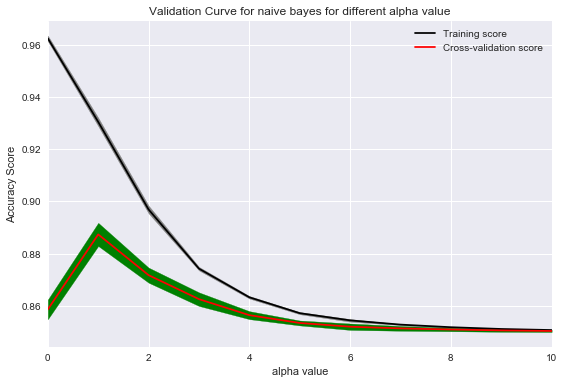

In [127]:
import warnings
warnings.filterwarnings('ignore')

from sklearn.model_selection import validation_curve

#create plot for training and test validation
# Calculate accuracy on training and test set using range of parameter values
alpha=[0,1,2,3,4,5,6,7,8,9,10]
param_range=[0,1,2,3,4,5,6,7,8,9,10]

train_scores, test_scores = validation_curve(clf1, X_train, y_train, param_name="alpha",param_range=alpha,cv=5)

train_scores_mean = np.mean(train_scores, axis=1)
train_scores_std = np.std(train_scores, axis=1)
test_scores_mean = np.mean(test_scores, axis=1)
test_scores_std = np.std(test_scores, axis=1)

plt.plot(param_range, train_scores_mean, label="Training score", color="black")
plt.plot(param_range, test_scores_mean, label="Cross-validation score", color="red")

#Plot accurancy bands for training and test sets
plt.fill_between(param_range, train_scores_mean - train_scores_std, train_scores_mean + train_scores_std, color="gray")
plt.fill_between(param_range, test_scores_mean - test_scores_std, test_scores_mean + test_scores_std, color="green")

plt.title("Validation Curve for naive bayes for different alpha value")
plt.xlabel("alpha value")
plt.ylabel("Accuracy Score")
plt.xlim(0,10)
plt.tight_layout()
plt.legend(loc="best")
plt.show()



# Show top 10 words in positive and negative review

In [128]:
count_vect.vocabulary_
print(len(clf.coef_[0]))
print(clf.coef_.shape)
print(clf.classes_)
print(clf.coef_[0])

def most_informative_feature_for_binary_classification(vectorizer, classifier, n=10):
    class_labels = classifier.classes_
    feature_names = vectorizer.get_feature_names()
    topn_class1 = sorted(zip(classifier.coef_[0], feature_names))[:n]
    #negative words are sorted with -ve
    topn_class2 = sorted(zip(classifier.coef_[0], feature_names))[-n:]

    for coef, feat in topn_class1:
        print (class_labels[0], coef, feat)

    print("\n")

    for coef, feat in reversed(topn_class2):
        print (class_labels[1], coef, feat)

print("Top 10 words for both review\n")
most_informative_feature_for_binary_classification(count_vect, clf)


18058
(1, 18058)
['negative' 'positive']
[-12.3525943  -12.3525943  -13.04574148 ..., -12.3525943  -12.3525943
 -13.04574148]
Top 10 words for both review

negative -13.0457414788 aaah
negative -13.0457414788 aani
negative -13.0457414788 aappubl
negative -13.0457414788 abdomen
negative -13.0457414788 abit
negative -13.0457414788 ablaz
negative -13.0457414788 abomin
negative -13.0457414788 abot
negative -13.0457414788 abrotanum
negative -13.0457414788 abrupt


positive -4.48357492169 like
positive -4.52256621566 tast
positive -4.66574352651 good
positive -4.71898266424 flavor
positive -4.72480650987 great
positive -4.72919676082 love
positive -4.75997605824 use
positive -4.81276968816 one
positive -4.9392269625 product
positive -4.94436680752 tea


# Use TFIDF and check performance

In [129]:
from sklearn.naive_bayes import GaussianNB
from sklearn.naive_bayes import MultinomialNB

tf_idf_vect = TfidfVectorizer()
final_counts = tf_idf_vect.fit_transform(clean_data['CleanedText'].values)

x=final_counts
y = clean_data['Score']
n=x.shape[0]
n1=int(n*.3)
X_test = x[0:n1,:]
X_train= x[n1:n+1,:]
y_test=y[0:n1]
y_train=y[n1:n+1]
print('size of X_train, X_test, y_train , y_test ',X_train.shape, X_test.shape,y_train.shape,y_test.shape)
print("positive and negative review in train and test\n",y_train.value_counts(),"\n",y_test.value_counts())

# Create 10 fold cross validation for different alpha

cv_score=[]
a=[]
for alphaval in range(1,30):
  clf = MultinomialNB(alpha=alphaval)
  clf.fit(X_train,y_train)
  score= cross_val_score(clf, X_train, y_train, cv=10, scoring='accuracy')
  cv_score.append(score.mean())
  a.append(alphaval)
  #print('score with alpha=',alphaval,score.mean())
 
print('best score and alpha',cv_score[cv_score.index(max(cv_score))],a[cv_score.index(max(cv_score))])    
optimalpha=a[cv_score.index(max(cv_score))]


# ============================== naive bayes with optimum alpha ===============================================
clf = MultinomialNB(alpha=optimalpha)
clf.fit(X_train,y_train)

pred = clf.predict(X_train)
mat=pd.crosstab(y_train, pred, rownames=['Actual'], colnames=['Predicted'], margins=True) 
tp=mat.iloc[1,1];tn=mat.iloc[0,0];fp=mat.iloc[0,1];fn=mat.iloc[1,0];precision=tp/(tp+fp) ;recall=tp/(tp+fn) 
fscoretrain=2*precision*recall/(precision+recall)



# fitting the model
clf.fit(X_train, y_train)

# predict the response
pred = clf.predict(X_test)

# evaluate accuracy
acc = accuracy_score(y_test, pred) * 100
print('\nThe accuracy of the naive bayes classifier using alpha and accuracy respectively become ',optimalpha, acc)



#Check accuracy 
print(confusion_matrix(y_test, pred))
# try better way
mat=pd.crosstab(y_test, pred, rownames=['Actual'], colnames=['Predicted'], margins=True) 
print(mat)
#positive is fraud, negative is not fraud 
tp=mat.iloc[1,1] 
tn=mat.iloc[0,0] 
fp=mat.iloc[0,1] 
fn=mat.iloc[1,0] 
precision=tp/(tp+fp) 
recall=tp/(tp+fn) 
fscore=2*precision*recall/(precision+recall)
print('precision,racall,f1score',precision,recall,fscore)

bb=pd.DataFrame({'type':['TFIDF '],'train_score_accuracy':[clf.score(X_train,y_train)],'train_score_fscore':[fscoretrain],'test_score_accuracy':[clf.score(X_test,y_test)],'test_score_fscore':[fscore],'Alpha':[clf.alpha]})
aa=aa.append(bb)


size of X_train, X_test, y_train , y_test  (14000, 18058) (6000, 18058) (14000,) (6000,)
positive and negative review in train and test
 positive    11907
negative     2093
Name: Score, dtype: int64 
 positive    4957
negative    1043
Name: Score, dtype: int64
best score and alpha 0.850500107252 7

The accuracy of the naive bayes classifier using alpha and accuracy respectively become  7 82.6166666667
[[   0 1043]
 [   0 4957]]
Predicted  positive   All
Actual                   
negative       1043  1043
positive       4957  4957
All            6000  6000
precision,racall,f1score 0.826166666667 0.5 0.622973482468


# Plot accuracy with alpha

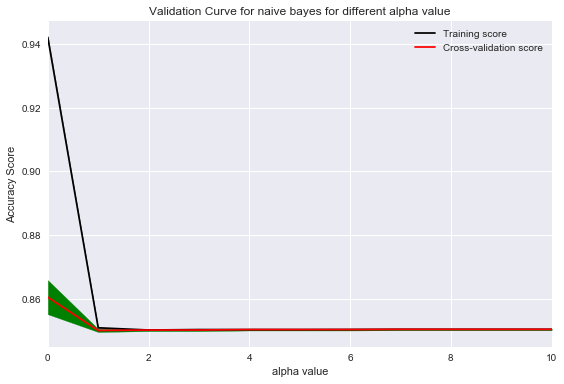

In [130]:
import warnings
warnings.filterwarnings('ignore')
from sklearn.model_selection import validation_curve
#create plot for training and test validation
alpha=[0,1,2,3,4,5,6,7,8,9,10]
param_range=[0,1,2,3,4,5,6,7,8,9,10]

train_scores, test_scores = validation_curve(MultinomialNB(), X_train, y_train, param_name="alpha",param_range=alpha,scoring='accuracy',cv=10)
#print(train_scores,test_scores)
train_scores_mean = np.mean(train_scores, axis=1)
train_scores_std = np.std(train_scores, axis=1)
test_scores_mean = np.mean(test_scores, axis=1)
test_scores_std = np.std(test_scores, axis=1)

plt.plot(param_range, train_scores_mean, label="Training score", color="black")
plt.plot(param_range, test_scores_mean, label="Cross-validation score", color="red")
plt.fill_between(param_range, train_scores_mean - train_scores_std, train_scores_mean + train_scores_std, color="gray")
plt.fill_between(param_range, test_scores_mean - test_scores_std, test_scores_mean + test_scores_std, color="green")
plt.title("Validation Curve for naive bayes for different alpha value")
plt.xlabel("alpha value")
plt.ylabel("Accuracy Score")
plt.xlim(0,10)
plt.tight_layout()
plt.legend(loc="best")
plt.show()

#plt.title("Validation Curve with NB")
#plt.xlabel("alpha")
#plt.ylabel("Score")
#plt.ylim(0.0, 1.1)
#lw = 2
#plt.semilogx(param_range, train_scores_mean, label="Training score", color="darkorange", lw=lw)
#plt.fill_between(param_range, train_scores_mean - train_scores_std, train_scores_mean + train_scores_std, alpha=0.2,                 color="darkorange", lw=lw)
#plt.semilogx(param_range, test_scores_mean, label="Cross-validation score", color="navy", lw=lw)
#plt.fill_between(param_range, test_scores_mean - test_scores_std, test_scores_mean + test_scores_std, alpha=0.2,color="navy", lw=lw)
#plt.legend(loc="best")
#plt.show()


# Here is the performance accuracy
Belo is the accuracy and f score of BOW and TFIDF

In [131]:
aa

,Alpha,test_score_accuracy,test_score_fscore,train_score_accuracy,train_score_fscore,type
0,1,0.884667,0.932422,0.931857,0.960815,BOW
0,7,0.826167,0.622973,0.850500,0.629767,TFIDF
